In [3]:
# Data handling
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Optimisation
import swifter
from scipy.sparse import csr_matrix

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, cmudict, stopwords
from collections import Counter
#nltk.download("punkt")
#nltk.download("averaged_perceptron_tagger")
#nltk.download("wordnet")
#nltk.download("stopwords")
#nltk.download("cmudict")

# Topic modelling
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# Readability & sentiment analysis
import textstat
from textblob import TextBlob

# ML
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Functions

In [4]:
# Data Loading

def load_data(filepath):
    """Loads data from a CSV file."""
    data = pd.read_csv(filepath, encoding="utf-8")
    df = data.copy()
    df = df.drop(columns=["prompt_id", "text_length", "word_count"])
    df["source"] = df["source"].apply(lambda x: 1 if x != "Human" else 0)
    return df

In [5]:
# Text Cleaning

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        self.symbols_to_keep = {"$", "-", "%"}

    def get_wordnet_pos(slef,text):
        """Convert NLTK POS tag to a format suitable for WordNet Lemmatizer."""
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        tag = nltk.pos_tag([text])[0][1][0].upper() if text else "N" # Default to NOUN
        return tag_dict.get(tag, wordnet.NOUN)

    def text_cleaning(self,text):
        """Clean text but preserve some symbols and numbers."""
        if not isinstance(text, str):  # Handle non-string input
            return ""

        text = text.lower().strip() # Turn to all lowercase & remove whitespace
        text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove non-ASCII characters
        text_clean = "".join(char if char not in string.punctuation or char in self.symbols_to_keep else "" for char in text)

        tokenized = word_tokenize(text_clean)
        tagged_words = nltk.pos_tag(tokenized)
        lemmatizer = WordNetLemmatizer()
        lemmatized = [self.lemmatizer.lemmatize(word, self.get_wordnet_pos(word)) for word, _ in tagged_words]
        cleaned_text = " ".join(lemmatized)
        return cleaned_text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply cleaning to text column."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X["text"] = X["text"].apply(self.text_cleaning)
            return X

        elif isinstance(X, pd.Series):
            return X.apply(self.text_cleaning)

        raise ValueError("Expected DataFrame or Series with a 'text' column")

In [6]:
# Feature Extraction

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cmu_dict = cmudict.dict()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))
        self.common_ai_words = set([
            "commendable", "transhumanist", "meticulous", "elevate", "hello", "tapestry", "leverage",
            "journey", "headache", "resonate", "testament", "explore", "binary", "delve",
            "enrich", "seamless", "multifaceted", "sorry", "foster", "convey", "beacon",
            "interplay", "oh", "navigate", "form", "adhere", "cannot", "landscape", "remember",
            "paramount", "comprehensive", "placeholder", "grammar", "real", "summary", "symphony",
            "furthermore", "relationship", "ultimately", "profound", "art", "supercharge", "evolve",
            "beyond", "reimagine", "vibrant", "robust", "pivotal", "certainly", "quinoa", "orchestrate", "align",
            "diverse", "recommend", "annals", "note", "employ", "bustling", "indeed", "digital", "enigma", "outfit",
            "indelible", "refrain", "culture", "treat", "emerge", "esteemed", "weight", "whimsical", "bespoke",
            "highlight", "antagonist", "unlock", "key", "breakdown", "tailor", "misinformation", "treasure",
            "paradigm", "captivate", "song", "underscore", "calculate", "especially", "climate", "hedging",
            "inclusive", "exercise", "ai", "embrace", "level", "nuance", "career", "dynamic", "accent",
            "ethos", "cheap", "firstly", "online", "goodbye"])
        self.scaler = StandardScaler()


    def get_word_stress(self, word):
        """Calculate stress score for a single word using CMU dictionary."""
        word = word.lower()

        if word in self.cmu_dict:
            return sum(int(char) for syllable in self.cmu_dict[word][0] for char in syllable if char.isdigit())

        elif word.upper() in self.cmu_dict:
            return sum(int(char) for syllable in self.cmu_dict[word.upper()][0] for char in syllable if char.isdigit())

        return 0  # If not found, return 0


    def get_sentence_stress(self, sentence):
        """Calculate total stress score for a sentence."""
        if not isinstance(sentence, str) or not sentence.strip():
            return 0

        words = sentence.split()
        stress_values = [self.get_word_stress(word) for word in words]
        return sum(stress_values)


    def cons_density(self, text):
        """Calculate consonant density in text."""
        if not isinstance(text, str) or not text.strip():
            return 0.0
        consonant = sum(1 for char in text if char.isalpha() and char not in "aeiouAEIOU")
        vowel = sum(1 for char in text if char.isalpha() and char in "aeiouAEIOU")
        return round((consonant/(vowel + consonant)),3)


    def redundance(self, text):
        """Compute redundancy score based on repeated words."""
        if not isinstance(text, str) or not text.strip():
            return 0

        tokens = word_tokenize(text)
        clean_tokens = [w for w in tokens if w not in self.stop_words]

        final_lemmas = [self.lemmatizer.lemmatize(self.lemmatizer.lemmatize(word, 'v'), 'n') for word in clean_tokens]

        word_counts = Counter(final_lemmas)
        if len(word_counts) == 0:
            return 0  # Prevent division by zero if no tokens remain

        mean_freq = sum(word_counts.values()) / len(word_counts)
        score = sum(1 for word, count in word_counts.items() if count > 3 * mean_freq)

        return score


    def sentiment_polarity(self, text):
        """Compute sentiment polarity (0 to 1), with smoothing for better balance."""
        if not isinstance(text, str) or not text.strip():
            return 0.0  # Handle empty or None inputs safely

        sent_pol = TextBlob(text).sentiment.polarity
        abs_pol = abs(round(sent_pol, 3))
        return 0.0 if abs_pol < 0.1 else min(abs_pol, 0.8)


    def word_choice(self, text):
        """Count number of AI-associated words in the text."""
        if not isinstance(text, str) or not text.strip():
            return 0
        return sum(1 for word in text.split() if word in self.common_ai_words)


    def coherence(self, text):
        """Compute coherence score using LSA model."""
        if not isinstance(text, str) or not text.strip():
            return 0.0

        tokens = word_tokenize(text)
        if not tokens:
            coherence_score = 0
        else:
            dictionary = corpora.Dictionary([tokens])
            corpus_gensim = [dictionary.doc2bow(tokens)]
            lsa_model = LsiModel(corpus_gensim, id2word=dictionary, num_topics=5)

            coherence_model = CoherenceModel(
                model=lsa_model,
                texts=[tokens],
                dictionary=dictionary,
                coherence='c_v')

            coherence_score = coherence_model.get_coherence()
        return coherence_score


    def reading_ease(self, text):
        """Returns Flesch Reading Ease score (higher = easier to read)."""
        if not isinstance(text, str) or not text.strip():
            return 0.0  # Handle empty or None input safely
        return textstat.flesch_reading_ease(text)


    def gunning_fog(self,text):
        """Returns Gunning Fog Index (higher = more difficult to read)."""
        if not isinstance(text, str) or not text.strip():
            return 0.0  # Handle empty or None input safely
        return textstat.gunning_fog(text)


    def extract_features(self, text):
        """Process a batch of text inputs using Swifter for faster feature extraction."""
        if isinstance(text, list) or isinstance(text, np.ndarray):
            text = pd.Series(text)  # Ensure Swifter works properly

        results = text.swifter.apply(lambda t: [
            np.mean([self.get_word_stress(word) for word in t.split()]) if t.split() else 0,
            self.get_sentence_stress(t),
            self.cons_density(t),
            self.redundance(t),
            self.sentiment_polarity(t),
            self.word_choice(t),
            self.coherence(t),
            self.reading_ease(t),
            self.gunning_fog(t)
        ])

        return np.array(results.tolist())


    def fit(self, X, y=None):
        """Fit the scaler using training data."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            features = self.extract_features(X["text"])
        else:
            features = self.extract_features(X)

        self.scaler.fit(features)
        return self


    def transform(self, X):
        """Extract and scale features from text column."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            features = self.extract_features(X["text"])
        else:
            features = self.extract_features(X)

        return self.scaler.transform(features)

In [7]:
# TF-IDF Vectorization

class TFIDFVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10000, ngram_range=(1, 2), stop_words="english"):
        """
        Custom TF-IDF vectorizer with optimizations.
        - max_features: Limits vocabulary size to the most important words.
        - ngram_range: (1,1) for unigrams, (1,2) for bigrams, etc.
        """
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.stop_words = stop_words
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words=stop_words)

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]  # Extract the 'text' column
        if not isinstance(X, (list, pd.Series)) or len(X) == 0:
            raise ValueError("Input must be a non-empty list or pandas Series of text.")
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        """Transforms text data into TF-IDF feature vectors."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]  # Extract the 'text' column
        if not isinstance(X, (list, pd.Series)) or len(X) == 0:
            raise ValueError("Input must be a non-empty list or pandas Series of text.")
        return self.vectorizer.transform(X)

In [8]:
class DenseTransformer:
    """Ensures output is converted to a dense NumPy array."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray() if hasattr(X, "toarray") else np.array(X)

In [9]:
# Model Training

class GradientBoostingClassifierWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=200, learning_rate=0.1, max_depth=3, early_stopping_rounds=10):
        """
        Custom wrapper for Gradient Boosting Classifier.
        - n_estimators: Number of boosting stages.
        - learning_rate: Shrinks contribution of each tree.
        - max_depth: Maximum depth of individual estimators.
        - early_stopping_rounds: Stops training when validation loss doesn't improve.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None


    def fit(self, X, y):
        """Train Gradient Boosting model."""
        if X is None or y is None or len(X) == 0 or len(y) == 0:
            raise ValueError("Training data (X, y) must not be empty.")

        self.model = GradientBoostingClassifier(
            n_estimators = self.n_estimators,
            learning_rate = self.learning_rate,
            max_depth = self.max_depth,
            n_iter_no_change = self.early_stopping_rounds)

        self.model.fit(X, y)
        return self


    def predict(self, X):
        """Predict with the trained Gradient Boosting model."""
        if self.model is None:
            raise ValueError("Model has not been trained. Call `fit()` first.")
        return self.model.predict(X)


    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.model is None:
            raise ValueError("Model has not been trained. Call `fit()` first.")
        return self.model.predict_proba(X)

In [17]:
# Model Evaluation

class EvaluationPipeline:
    def __init__(self, model):
        """Initialize with a trained model."""
        self.model = model

    def fit(self, X, y=None):
        """Fit method (not used, but required for Scikit-learn compatibility)."""
        return self

    def evaluate(self, X_test, y_test):
        """Evaluate the trained model on test data."""
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]

        results = {
            "loss": log_loss(y_test, y_pred_proba),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba)}

        # Print performance
        print("Model Performance:")
        print(f"Loss: {results['loss']:.4f}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"ROC-AUC: {results['roc_auc']:.4f}")

        # Compare Actual vs. Predicted
        comparison_df = pd.DataFrame({
            "Actual": y_test.values,
            "Predicted": y_pred,
            "AI Probability": y_pred_proba})

        # Format probability values to 4 decimal places
        comparison_df["AI Probability"] = comparison_df["AI Probability"].apply(lambda x: f"{x:.2%}")

        print("**Actual vs. Predicted Results:**")
        print(comparison_df)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
        plt.xlabel("Predicted Label")
        plt.ylabel("Actual Label")
        plt.title("Confusion Matrix")
        plt.show()

# Pipelines

In [27]:
text_cleaning_pipeline = Pipeline([('clean_text', TextCleaner())])

feature_extraction_pipeline = Pipeline([("feature_extraction", FeatureExtractor())])

tfidf_pipeline = Pipeline([
    ("tfidf", TFIDFVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words="english"))])

# Combine TF-IDF with the Scaled Feature Extraction
combined_features = Pipeline([
    ("feature_union", FeatureUnion([
        ("tfidf", tfidf_pipeline),
        ("scaled_features", feature_extraction_pipeline)])),
    ("to_dense", DenseTransformer())]) # Convert to NumPy array

final_pipeline = Pipeline([
    ("text_cleaning", text_cleaning_pipeline),
    ("combine_features", combined_features),
    ("classifier", GradientBoostingClassifierWrapper(n_estimators=200, learning_rate=0.1, max_depth=3))])

evaluator = EvaluationPipeline(model=final_pipeline)

# UI prediction
ui_pred_pipe = Pipeline([
    ("text_cleaning", text_cleaning_pipeline),
    ("combine_features", combined_features),
    ("classifier", final_pipeline.named_steps["classifier"])]) # Use trained classifier

In [ ]:
# Predict Text (UI)

class TextClassificationModel:
    def __init__(self, pipeline):
        """Wrap the pre-trained pipeline."""
        self.pipeline = pipeline

    def predict_text(self, input_text):
        """Predict a single text input (for UI usage)."""
        if self.pipeline is None:
            raise ValueError("Model has not been initialized properly.")

        # Ensure input is in a DataFrame with 'text' column
        df = pd.DataFrame({"text": [input_text]})

        # Apply preprocessing + prediction
        y_pred = self.pipeline.predict(df)[0]
        y_pred_proba = self.pipeline.predict_proba(df)[:, 1][0]  # Probability of AI class (1)

        # Format probability as percentage
        probability = f"{y_pred_proba * 100:.2f}%"

        return {"Prediction": "AI" if y_pred == 1 else "Human", "AI Probability": probability}

model = TextClassificationModel(ui_pred_pipe)

# Test Use

In [19]:
df = load_data("../data/1k_sampled_dataset.csv")
df_sample = df.sample(50)

df_sample.head()

,text,source
635,Just over eight years ago there was a solar fl...,0
518,The Analysis of Siamangs’ Behavior in a Zoo Se...,0
579,Tiffany wanted to take a bath. While in the ba...,1
850,Bipolar Disorder Patient Examination and Thera...,0
175,To What Extent Is Policy-Making Being European...,0


In [14]:
df_sample.shape

(50, 2)

In [15]:
df_sample["source"].value_counts(normalize=True)

source
0    0.54
1    0.46
Name: proportion, dtype: float64

Pandas Apply: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

Model Performance:
Loss: 0.6455
Accuracy: 0.7000
Precision: 1.0000
Recall: 0.2500
ROC-AUC: 0.8750
**Actual vs. Predicted Results:**
   Actual  Predicted AI Probability
0       0          0         33.69%
1       0          0          6.68%
2       0          0          5.48%
3       0          0          8.56%
4       1          1         91.28%
5       1          0         10.29%
6       1          0         14.49%
7       1          0         24.19%
8       0          0          5.48%
9       0          0          5.48%


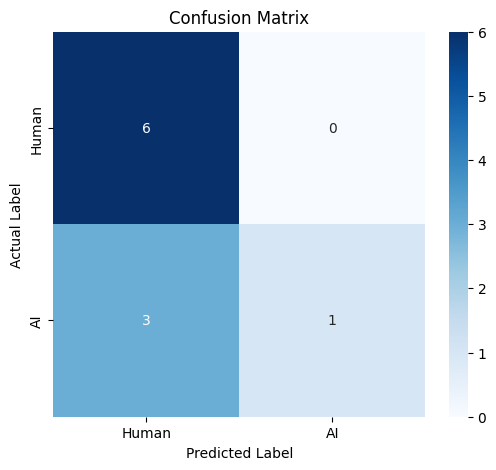

In [30]:
X = df_sample["text"]  # Raw text input
y = df_sample["source"]  # Labels (0=Human, 1=AI)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_pipeline.fit(X_train, y_train)

results = evaluator.evaluate(X_test, y_test)
results

In [35]:
test01 = "Melbourne, Australia, is renowned for its vibrant and sophisticated coffee culture, often considered one of the best in the world. The city’s laneways are dotted with cozy cafes, each offering meticulously crafted brews that reflect a deep passion for quality and artistry. From flat whites to single-origin pour-overs, Melbourne’s baristas are skilled artisans, dedicated to perfecting every cup. The coffee scene here is more than just a drink—it’s a lifestyle, a social ritual, and a celebration of community. Locals take pride in their coffee knowledge, favoring independent roasters and ethically sourced beans. Whether it’s a hidden gem in Degraves Street or a trendy spot in Fitzroy, Melbourne’s coffee culture is an immersive experience, blending innovation with tradition, and creating a haven for coffee lovers from around the globe."

y_pred = model.predict_text(test01)
y_pred

Pandas Apply: 100%|██████████| 1/1 [00:00<00:00, 7307.15it/s]


{'Prediction': 'AI', 'AI Probability': '89.07%'}

In [34]:
test02= "Ubud, located in the heart of Bali, Indonesia, is a cultural and artistic haven renowned for its lush landscapes, vibrant traditions, and serene atmosphere. Surrounded by terraced rice paddies, dense jungles, and sacred rivers, Ubud is a paradise for nature lovers and spiritual seekers. The town is famous for its traditional dance performances, intricate handicrafts, and bustling art markets. Visitors can explore ancient temples like the Ubud Monkey Forest or Tirta Empul, indulge in holistic wellness at yoga retreats, or savor authentic Balinese cuisine. Ubud’s unique blend of natural beauty, rich heritage, and creative energy makes it a must-visit destination for travelers seeking inspiration and tranquility."

y_pred = model.predict_text(test02)
y_pred

Pandas Apply: 100%|██████████| 1/1 [00:00<00:00, 8422.30it/s]


{'Prediction': 'AI', 'AI Probability': '89.07%'}

In [ ]:
# Save model

#joblib.dump(ui_pred_pipe, "../export/gradient_boost_model.pkl")

['export/gradient_boost_model.pkl']